### MSE를 Loss function으로 사용하는 경우 한계
loss fuction으로 MSE를 사용하는 경우 weak model은 residual에 대해 학습하게 되고, composite model을 각 leaf node의 평균 값으로 예측하게 된다. 불행하게도 MSE를 손실함수로 정의하는 경우에는 composite model이 outlier의 영향을 많이 받게 된다. 그 이유는 평균이라는 통계량이 outlier에 영향을 많이 받기 때문이다.
  
위와 같은 이유로 인해 outlier가 많이 존재할 경우, weak model이 방향과 크기를 모두 가지는 residual을 학습하는 모델보다는 $F_{m-1}$에서 $y$로의 방향에만 집중하는 모델을 학습하는 것이 더 합리적일 것이다.

### Sign Vector
**sign vector**: $sign(y_i - F_{m-1}(x_i))$  
sign vector의 원소들은 {-1, 0, 1} 중 하나의 값을 가지게 된다. sign vector를 사용할 경우 실제값이 현재 예측값과 얼마나 떨어져 있는지는 상관없이 방향 정보만을 사용해서 weak model들이 학습된다. **While we train the weak models on the sign vector, the weak models are modified to predict a residual not a sign vector! (A stump leaf predicts the median of all the residuals within that leaf, to be precise.) More on this later.**

  
target 변수에 제거할 수 없는 outlier가 존재할 경우 크기와 방향 모두가 아닌, 방향에만 우리의 weak model을 학습시키는 것이 더 낫다. $sign(y - F_{m-1}(x_i))$를 사용하는 경우 MAE(Mean Absolute Error or L1 loss) 손실함수로 해 모델을 최적화 하는 것과 같다.
  
MAE에 대해 최적화할 경우 우리는 평균이 아닌 중앙값으로 $f_0$를 셋팅해야한다. 그 이유는 중앙값이 L1 loss를 최소화하는 상수값이기 때문이다.

> $F_0(x) = f_0(x)$  
> $F_m(x) = F_{m-1} + \eta\Delta_m(x)$  

위의 식은 MSE에 대해 최적화할 때와 같다. 즉, $f_0$와 $\Delta_m$이 추정하는 값이 다를 뿐 학습과정은 MSE가 손실함수일 때와 같다.

In [9]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
sqfeet = np.array([750, 800, 850, 900, 950]) # feature
rent = np.array([1160, 1200, 1280, 1450, 2000]) # target

dataset = pd.DataFrame({
    'sqfeet' : sqfeet,
    'rent' : rent
})
display(Markdown('### Orignal Dataset'), dataset)

### Orignal Dataset

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


In [10]:
f_0 = np.median(dataset['rent'])
F_0 = f_0
residual = dataset['rent'] - F_0
sign_residual = np.sign(residual)

dataset['$F_0$'] = np.zeros_like(residual) + F_0
dataset['y - $F_0$'] = residual
dataset['sign(y - $F_0$)'] = sign_residual

display(Markdown('$F_0(x)$는 중앙값으로 예측'), dataset)

$F_0(x)$는 중앙값으로 예측

,sqfeet,rent,$F_0$,y - $F_0$,sign(y - $F_0$)
0,750,1160,1280.0,-120.0,-1.0
1,800,1200,1280.0,-80.0,-1.0
2,850,1280,1280.0,0.0,0.0
3,900,1450,1280.0,170.0,1.0
4,950,2000,1280.0,720.0,1.0


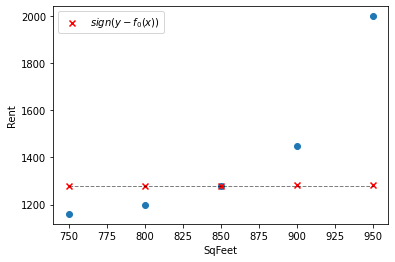

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(dataset['sqfeet'], dataset['rent'])
plt.hlines(1280, 750, 950, linestyle = '--', linewidth = 1, alpha = .5, color = 'black')
plt.scatter(dataset['sqfeet'], dataset['sign(y - $F_0$)'] + 1280, marker = 'x', color = 'red', label = '$sign(y - f_0(x))$')
plt.xlabel('SqFeet')
plt.ylabel('Rent')
plt.legend();


- 위의 그래프를 확대해서 보면 sign vector의 원소들이 예측값 $f_0(x)$에서 실제값 $y_i$의 방향을 잘 나타내고 있음을 볼 수 있다.

### Two perspectives on training weak models for L1 loss
**objective**: 초기 예측값인 $f_0(x)$가 실제 target vector인 $y$로 향할 수 있도록 하는 weak model인 regression tree($\Delta_m$)의 series를 만드는 것

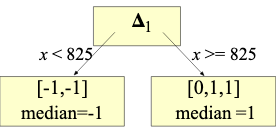

> 첫번째 tree인 \Delta_1은 $sign(y - F_0(x))$에 대해 학습해야 한다.  
> 또한 L1 loss를 사용했기 때문에 각 leaf node의 예측값은 평균이 아닌 중앙값이 되어야 한다.
  
